In [ ]:
## Work Sample for Dow Jones
## Author: Jeff Hudson
## Date: August 19, 2015

## SUMMARY:
##  This is my current project, still in progress but showcases my skill using Python for 
##   data munging and exploratory data analysis.
##  This project is an exploration of NYC MTA turnstile data.
##  Final product will include machine learning algorithms with the full year's data in pySpark 
##   to predict ridership for the subsequent week (validated and updated weekly with newly released data)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib2
% matplotlib inline

In [2]:
date = "150808" ## LATER: update to pull most recent week or take an argument
url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_" + date + ".txt"
data = urllib2.urlopen(url)
df = pd.read_csv(data)

In [3]:
df.head()

## it works!!

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,08/01/2015,00:00:00,REGULAR,5249369,1775966
1,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,08/01/2015,04:00:00,REGULAR,5249393,1775968
2,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,08/01/2015,08:00:00,REGULAR,5249415,1775987
3,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,08/01/2015,12:00:00,REGULAR,5249519,1776069
4,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,08/01/2015,16:00:00,REGULAR,5249751,1776111


In [4]:
## check for irregular rows

irreg = sum(df.DESC != "REGULAR")

recoverd = sum(df.DESC == "RECOVR AUD")

## verify that all irregular rows are "recovered audits"
assert(irreg == recoverd)

In [5]:
## filter out PATH trains (DIVISION = "PTH")
lenbefore = len(df)
df2 = df[df.DIVISION != "PTH"]
lenafter = len(df2)

assert(lenbefore > lenafter) # requires that PATH trains are always included; shouldn't be a problem though
assert(sum(df2.DIVISION == "PTH") == 0)
df = df2

In [26]:
## aggregate by station (we don't care about individual devices)
##  while preserving date/time data

## GROUP_BY station, linename, date, time AGGREGATE entries, exits BY sum
aggdf = df.groupby(["STATION","LINENAME","DATE","TIME"]).sum()
aggdf.head()
## some stations share a name, but no stations on the same line share a name, thus use of both STATION and LINENAME
##  (some stations also have multiple UNITs)

ENTRIES  \
STATION LINENAME DATE       TIME                   
1 AVE   L        08/01/2015 00:00:00  1404469489   
                            04:00:00  1404471670   
                            08:00:00  1404472343   
                            12:00:00  1404475276   
                            16:00:00  1404480057   

                                      EXITS                                                                 
STATION LINENAME DATE       TIME                                                                            
1 AVE   L        08/01/2015 00:00:00                                         1465927127                     
                            04:00:00                                         1465928311                     
                            08:00:00                                         1465929324                     
                            12:00:00                                         1465931908                     
                            16:00:00                                         1465935943

In [34]:
## some rows are missing -- 103rd St 1 line 8/6/2015 at 9:00am reading missing.
##  how do we identify more such rows?
##    after subtracting prv row value, these rows should be the only ones with negative values
##  how do we fix them?
##    a. remove row entirely (won't someone PLEASE think of the DATA!!)
##    b. interpolate (split the diff btwn next and previous rows) (ideal, but futzier)
##    c. subtract cumulative totals before agg'ing (missing entries will accrue to next row) (easier to implement)

## subtract previous row values for all entries and exits to get total during period
agg = df.groupby(["UNIT", "SCP", "STATION","LINENAME"])
obj = pd.DataFrame()

for name, group in agg:
    
    group = group.reset_index(drop=True)
    
    ## set first value of each device to zero (baseline)
    nc_ent = [0]
    nc_ext = [0]

    ## starting with the 2nd entry for each device, 
    ##  subtract raw counts for previous reading to get changes during time period
    
    for i in range(1,len(group)):
        nc_ent.append(group.values[i][9]-group.values[i-1][9])
        nc_ext.append(group.values[i][10]-group.values[i-1][10])
    
    
    ## add non-cumulative (NC) counts to the group's dataframe
    out = pd.concat([group,
                     pd.Series(nc_ent,name="NC_ENTRIES"),
                     pd.Series(nc_ext,name="NC_EXITS")], axis=1)
    
    ## concatenate the augmented dataframe to the new "obj" dataframe
    obj = pd.concat([obj,out],ignore_index=True)

In [35]:

## Check for negative values

obj[obj.NC_ENTRIES < 0].head()


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,NC_ENTRIES,NC_EXITS
2185,J034,R007,00-00-02,104 ST,JZ,BMT,08/01/2015,04:00:00,REGULAR,2026228302,622270628,-7,-9
2186,J034,R007,00-00-02,104 ST,JZ,BMT,08/01/2015,08:00:00,REGULAR,2026228264,622270614,-38,-14
2187,J034,R007,00-00-02,104 ST,JZ,BMT,08/01/2015,12:00:00,REGULAR,2026228205,622270602,-59,-12
2188,J034,R007,00-00-02,104 ST,JZ,BMT,08/01/2015,16:00:00,REGULAR,2026228156,622270562,-49,-40
2189,J034,R007,00-00-02,104 ST,JZ,BMT,08/01/2015,20:00:00,REGULAR,2026228119,622270516,-37,-46


In [9]:
print sum(obj.NC_ENTRIES < 0)
print sum(obj.NC_ENTRIES < 0) / 42 ## 7 days * 6 collections per day = 42 entries for each device

## Several of the devices appear to be counting down rather than up. (1145 total negative records; ~ 27 devices)
##  It could be that their data is completely erroneous but I find that unlikely given that
##  the magnitudes in the daily patterns they report are sync with other (non-faulty) devices.
## Solutions?
##  a. identify each such device and multiply their figures by -1 (differences should remain constant)
##  b. remove from dataset entirely (my precious data!)
##  c. take absolute value for all entries

## Solution C
##  assumes that all devices malfunctioned in the same, acceptable way. simply counting down instead of up.
##  if there are some extreme values (10K+ for instance) we will catch them further downstream

obj.NC_ENTRIES = abs(obj.NC_ENTRIES)
obj.NC_EXITS = abs(obj.NC_EXITS)

obj.describe()

1145
27


,ENTRIES,EXITS,NC_ENTRIES,NC_EXITS
count,1.800060e+05,1.800060e+05,1.800060e+05,1.800060e+05
mean,3.288954e+07,2.706664e+07,1.749209e+04,6.053165e+03
std,1.882045e+08,1.712966e+08,4.566093e+06,2.132906e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.425530e+05,3.498950e+05,1.200000e+01,9.000000e+00
50%,2.656890e+06,1.605210e+06,8.300000e+01,5.600000e+01
75%,6.413629e+06,4.654803e+06,2.570000e+02,1.740000e+02
max,2.118720e+09,2.087387e+09,1.504094e+09,9.024604e+08


In [36]:
## some show over 10^9 entries during a given hour. this seems unlikely. let's take a look.

obj[obj.NC_ENTRIES > 5000].head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,NC_ENTRIES,NC_EXITS
17695,N505,R022,02-06-01,34 ST-HERALD SQ,BDFMNQR,IND,08/02/2015,16:00:00,REGULAR,117440596,77,114496385,-1009581
19221,N606,R025,00-00-01,JAMAICA CENTER,EJZ,IND,08/04/2015,12:00:00,REGULAR,1207432441,1323,1205255819,-7855784
85808,N120A,R153,01-05-00,UTICA AVE,AC,IND,08/02/2015,13:00:00,REGULAR,50331653,16777216,50330302,16777216
129819,H017,R265,00-00-02,MONTROSE AVE,L,BMT,08/01/2015,12:00:00,REGULAR,134219572,18,133354760,-270874
135649,N112A,R284,01-06-01,CLINTON-WASH AV,C,IND,08/07/2015,12:00:00,REGULAR,150995002,50331652,66812204,50235537


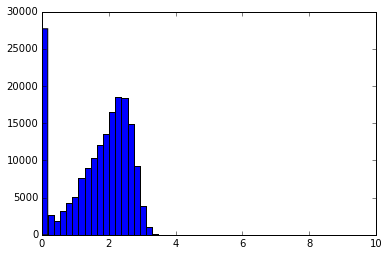

In [11]:
## Let's make a histogram to see where we should make the cut

entrynums = obj.NC_ENTRIES.copy() ## avoid tampering with the dataset unless necessary

entrynums += 1 ## add 1 to all (since we need to take log, cannot have zeros. 
               ##               this is a quick solution that does not compromise the shape of the histogram)

plt.hist(np.log10(entrynums),bins=50)
plt.show()

In [12]:
## Neat!! well, it looks like anything over a power of 4 (10,000) is an extreme outlier and most likely bad data.
##  In fact, we can look at the data and determine that anything above 5k can be dropped.
##    (closest legit data is ~3k from Grand Central)
##    this knocks out 19 readings out of about 180K (not bad)

ndf = obj[obj.NC_ENTRIES < 5000]

In [13]:
ndf.describe()

,ENTRIES,EXITS,NC_ENTRIES,NC_EXITS
count,1.799870e+05,1.799870e+05,179987.000000,179987.000000
mean,3.287540e+07,2.706409e+07,184.636396,141.689589
std,1.881612e+08,1.712929e+08,260.233661,233.219676
min,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,6.427545e+05,3.500425e+05,12.000000,9.000000
50%,2.656949e+06,1.605755e+06,83.000000,56.000000
75%,6.413418e+06,4.654835e+06,257.000000,174.000000
max,2.118720e+09,2.087387e+09,3366.000000,5197.000000


In [14]:
## we should do the same with exits, however maximum number of exits is 5197, which seems reasonable
##  let's just check to make sure it is a time/station for which that may be plausible.

ndf[ndf.NC_EXITS > 5000]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,NC_ENTRIES,NC_EXITS
36397,R241A,R048,00-00-00,42 ST-GRD CNTRL,4567S,IRT,08/06/2015,13:00:00,REGULAR,12959071,25997628,230,5197


In [15]:
## again it's grand central, this time at the morning rush hour. This makes sense.

In [16]:
## Next let's explore the data a bit:
##  Step 1: Aggregate the data by station to compare ridership at different stops
##           and different lines
##  Step 2: Aggregate all stations by day/time to visualize daily/weekly patterns

## Step 1

## First let's make the station names unique by appending the linename to them. 
##  Not necessarily pretty but effective.

comparison_set = ndf.copy()
## Always use a copy! don't alter the original dataset in case we want to use it to do something else later
##   Also useful for prototyping when we go back and make revisions, we want to start from scratch each time
##    not build off previous mistakes or need to correct them first

comparison_set.STATION = comparison_set.STATION + " " + comparison_set.LINENAME

comparison_set.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,NC_ENTRIES,NC_EXITS
0,A060,R001,00-00-00,WHITEHALL ST R1,R1,BMT,08/01/2015,01:00:00,REGULAR,1382501,1487997,0,0
1,A060,R001,00-00-00,WHITEHALL ST R1,R1,BMT,08/01/2015,05:00:00,REGULAR,1382547,1488022,46,25
2,A060,R001,00-00-00,WHITEHALL ST R1,R1,BMT,08/01/2015,09:00:00,REGULAR,1382761,1488055,214,33
3,A060,R001,00-00-00,WHITEHALL ST R1,R1,BMT,08/01/2015,13:00:00,REGULAR,1383125,1488228,364,173
4,A060,R001,00-00-00,WHITEHALL ST R1,R1,BMT,08/01/2015,17:00:00,REGULAR,1383743,1488414,618,186


In [17]:
## now let's group by station to compare raw figures for the whole week

compare_stations = comparison_set.groupby("STATION").sum()

# Entries
print compare_stations.sort("NC_ENTRIES",ascending=False).head(15).NC_ENTRIES ## top subway stations
print compare_stations.sort("NC_ENTRIES",ascending=True).head(15).NC_ENTRIES ## bottom subway stations

# Exits
print compare_stations.sort("NC_EXITS",ascending=False).head(15).NC_EXITS ## top subway stations
print compare_stations.sort("NC_EXITS",ascending=True).head(15).NC_EXITS ## bottom subway stations

STATION
42 ST-GRD CNTRL 4567S          902996
34 ST-HERALD SQ BDFMNQR        752262
42 ST-TIMES SQ 1237ACENQRS     579636
42 ST-PA BUS TE ACENQRS1237    572961
34 ST-PENN STA ACE             506108
14 ST-UNION SQ LNQR456         442379
86 ST 456                      382937
MAIN ST 7                      375525
47-50 ST-ROCK BDFM             346750
34 ST-PENN STA 123ACE          335972
59 ST-COLUMBUS ABCD1           325093
ROOSEVELT AVE EFMR7            312108
CANAL ST JNQRZ6                300912
59 ST 456NQR                   293258
W 4 ST-WASH SQ ABCDEFM         258517
Name: NC_ENTRIES, dtype: int64
STATION
34 ST-HUDSON YD 7      29
BROAD CHANNEL AS     2187
BEACH 105 ST AS      3520
BEACH 44 ST A        4091
TOMPKINSVILLE 1      4567
ORCHARD BEACH 6      5128
ROCKAWAY BLVD A      5697
E 143 ST 6           5730
BEACH 36 ST A        6032
AVE X F              7138
AQUEDUCT-N CNDT A    8071
CYPRESS HILLS J      8200
BEACH 98 ST AS       8275
DITMAS AVE F         8475
22 AVE-BAY PKY F   

In [18]:
## This conforms to our expectations about which subway stations should have the most traffic
##  It's interesting to note, though, that most of the big ones get more entries than exits.
##   If we assume most traffic is from commuters, everyone who exits there in the morning 
##    will also enter there in the evening. Perhaps the devices miss the "exit only" turnstiles.
##   Otherwise there must be a reason for many people get to the vicinity of a station by a means other 
##    than subway then leave by subway (getting marked as an entry, with no corresponding exit)
##   For places like GC and Penn Station, those could be train riders. But again, most train riders eventually
##    make a return trip

## Well, great, let's keep going then. Let's compare lines.
##  First we need to split up the "LINENAME" column.
##  Ideally what we want is for each STATION with multiple lines to have 
##   multiple rows with a single line in the LINENAME

## Then let's consider our numbers. For stations with multiple lines, we can either count all entries for all lines
##  (overestimate) or we can divide by the number of lines (assumes each line is equally popular at each station)

##  While neither can help us reconstruct which lines passengers ACTUALLY took, we will go for the second one
##   this also avoids double-counting trips.

## To do this we need to iterate through each station, create a row per line in that station, and divide the totals
##  by the number of lines at the station

In [38]:
# single line stations return each row with no changes
# multi line stations return a row for each line in the original row
# multi line stations' line

def row_processor(row):
    lines = row.loc["LINENAME"]
    num_lines = len(lines)
    row["LINE_ENTRIES"] = row.NC_ENTRIES/num_lines
    row["LINE_EXITS"] = row.NC_EXITS/num_lines
    rows = []
    for line in lines:
        row.LINENAME = line
        rows.append(row.copy())  #always use a copy!
    return rows

new_rows = [] 
for index, row in comparison_set.copy().iterrows():
    new_rows.extend(row_processor(row))
    #if index % 1000 == 0:  ## for convenience to track progress (takes a couple minutes to run on my machine)
        #print index
line_compare = pd.concat(new_rows,axis=1,ignore_index=True)
line_compare.transpose().head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,NC_ENTRIES,NC_EXITS,LINE_ENTRIES,LINE_EXITS
0,A060,R001,00-00-00,WHITEHALL ST R1,R,BMT,08/01/2015,01:00:00,REGULAR,1382501,1487997,0,0,0,0
1,A060,R001,00-00-00,WHITEHALL ST R1,1,BMT,08/01/2015,01:00:00,REGULAR,1382501,1487997,0,0,0,0
2,A060,R001,00-00-00,WHITEHALL ST R1,R,BMT,08/01/2015,05:00:00,REGULAR,1382547,1488022,46,25,23,12
3,A060,R001,00-00-00,WHITEHALL ST R1,1,BMT,08/01/2015,05:00:00,REGULAR,1382547,1488022,46,25,23,12
4,A060,R001,00-00-00,WHITEHALL ST R1,R,BMT,08/01/2015,09:00:00,REGULAR,1382761,1488055,214,33,107,16


In [20]:
line_compare = line_compare.transpose()

In [22]:
## Perfect! now we can aggregate by line

compare_lines = line_compare.groupby("LINENAME").sum()

## looking at top 11 bc there are 22 total lines (really 24 but the three S lines are undifferentiated here)

print compare_lines.sort("LINE_ENTRIES",ascending=False).head(11).LINE_ENTRIES ## top subway lines
print compare_lines.sort("LINE_ENTRIES",ascending=True).head(11).LINE_ENTRIES ## bottom subway lines

print compare_lines.sort("LINE_EXITS",ascending=False).head(11).LINE_EXITS ## top subway lines
print compare_lines.sort("LINE_EXITS",ascending=True).head(11).LINE_EXITS ## bottom subway lines


LINENAME
6           2912037
1           2670595
R           2078586
F           1957331
7           1952341
C           1735304
A           1713658
4           1627935
2           1563257
5           1536001
B           1510165
Name: LINE_ENTRIES, dtype: int64
LINENAME
S            378738
Z            497536
G            623621
J            694438
L           1277222
Q           1331955
3           1369138
E           1376726
D           1397137
M           1404834
N           1490340
Name: LINE_ENTRIES, dtype: int64
LINENAME
6           2457811
1           1959629
7           1643877
F           1501263
R           1459547
C           1276855
A           1276276
N           1228539
4           1228153
B           1173033
5           1149280
Name: LINE_EXITS, dtype: int64
LINENAME
S            336396
Z            381043
G            389921
J            489803
L            978965
3            995649
D           1027559
Q           1064161
2           1107461
M           1111200
E      

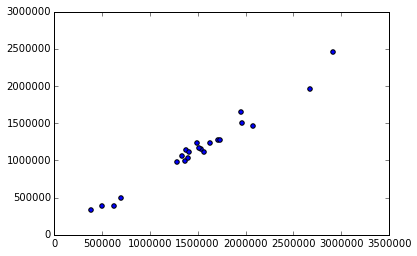

In [23]:
## it looks like line exits and entries are positively linearly correlated
##  we can investigate this casual observation by making a scatterplot and running a linear regression

plt.scatter(compare_lines.LINE_ENTRIES,compare_lines.LINE_EXITS)
plt.show()

## ADD QUICK LITTLE LINEAR REGRESSION HERE

In [24]:
## let's move on to step 2 and look at patterns over time

## first we need to convert date field and time field to one date-time field.
##  in real life, we'd want to go back and add this before we added roughly 300k rows to the dataset (to speed it up)
##  but for the sake of chronologically following along, we'll just do it here.

line_compare["DATETIME"] = pd.to_datetime(line_compare.DATE + " " + line_compare.TIME)
line_compare.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,NC_ENTRIES,NC_EXITS,LINE_ENTRIES,LINE_EXITS,DATETIME
0,A060,R001,00-00-00,WHITEHALL ST R1,R,BMT,08/01/2015,01:00:00,REGULAR,1382501,1487997,0,0,0,0,2015-08-01 01:00:00
1,A060,R001,00-00-00,WHITEHALL ST R1,1,BMT,08/01/2015,01:00:00,REGULAR,1382501,1487997,0,0,0,0,2015-08-01 01:00:00
2,A060,R001,00-00-00,WHITEHALL ST R1,R,BMT,08/01/2015,05:00:00,REGULAR,1382547,1488022,46,25,23,12,2015-08-01 05:00:00
3,A060,R001,00-00-00,WHITEHALL ST R1,1,BMT,08/01/2015,05:00:00,REGULAR,1382547,1488022,46,25,23,12,2015-08-01 05:00:00
4,A060,R001,00-00-00,WHITEHALL ST R1,R,BMT,08/01/2015,09:00:00,REGULAR,1382761,1488055,214,33,107,16,2015-08-01 09:00:00


In [25]:
onetrain = line_compare[line_compare.LINENAME == "1"].groupby(["STATION","DATETIME"]).NC_ENTRIES.sum()

onetrain.head(20)

STATION   DATETIME           
103 ST 1  2015-08-01 01:00:00       0
          2015-08-01 05:00:00     125
          2015-08-01 09:00:00     760
          2015-08-01 13:00:00    2444
          2015-08-01 17:00:00    2236
          2015-08-01 21:00:00    1846
          2015-08-02 01:00:00    1063
          2015-08-02 05:00:00     117
          2015-08-02 09:00:00     500
          2015-08-02 13:00:00    2234
          2015-08-02 17:00:00    2103
          2015-08-02 21:00:00    1603
          2015-08-03 01:00:00     654
          2015-08-03 05:00:00      71
          2015-08-03 09:00:00    2859
          2015-08-03 13:00:00    3122
          2015-08-03 17:00:00    2446
          2015-08-03 21:00:00    2364
          2015-08-04 01:00:00     871
          2015-08-04 05:00:00      76
Name: NC_ENTRIES, dtype: int64